# Import modules and files

We will use 3 modules: **pandas**, **seaborn** and **matplotlib**. 

**Pandas** is good for working with relations and building pivot.
**Seaborn** and **matplotlib** are useful for plotting the heatmap to demonstrate that our function is working correctly.

To demonstrate how the function works, we use two csv-files:

**problem1-reg_data.csv** is a file containing user registration dates.

**problem1-auth_data.csv** is a file containing user authorization dates. For this repository, this file was reduced in size by shortening the number of entries, since the original file exceeded the size allowed by GitHub.

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

reg_data = pd.read_csv('problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('problem1-auth_data.csv', sep=';')

# Function composing

In [38]:
def retention_per_day(reg, auth, start, end):
#   Merging Data: The function merges two dataframes auth_data and reg_data
    task_1 = auth_data.merge(reg_data, how='left', on='uid') 
    task_1 = task_1.reindex(columns=['uid', 'auth_ts', 'reg_ts'])
    
#   Time Format Conversion: Converts timestamps from Unix Time format to datetime. We need it to count Retention per day.
    task_1['auth_ts'] = pd.to_datetime(task_1.auth_ts, unit='s')
    task_1['reg_ts'] = pd.to_datetime(task_1.reg_ts, unit='s')

#   Converting timestamps to day format
    task_1['reg_ts'] = task_1.reg_ts.dt.to_period('D')
    task_1['auth_ts'] = task_1.auth_ts.dt.to_period('D')

#   Calculating Retention Rate
#   At first we group the data by registration dates and authentication dates and count unique user IDs
#   After that we add new columns: total (the total number of registrations for each day), retention (the percentage of retained users relative to the total number of registrations).
#   Finally, we round values to two decimal places
    task_1 = (task_1.groupby(['reg_ts', 'auth_ts'])[['uid']]\
                       .nunique()\
                       .assign(total = lambda x: x.groupby('reg_ts')[['uid']].transform(lambda x: x[0]),
                               retention = lambda x: 100 * x.uid / x.total)\
                       .reset_index()\
                       .round(2)
              )

#   Creating Pivot Table
    task_1_pivot = (task_1[['reg_ts', 'auth_ts', 'retention']]\
                             .pivot(columns='auth_ts', index='reg_ts')['retention']
                   )

#   Keep only rows and columns corresponding to the time interval from start to end
    task_1_pivot = task_1_pivot.loc[start:end, start:end]
    
    return task_1_pivot

# Result

As part of my analysis, I used data from the week between February 1, 2019, and February 8, 2019, to demonstrate player return dynamics during this period.

The function returns a DataFrame representing a table of user retention by day. The indices are registration days, the columns are authentication days, and the values are retention percentages.

Here we can see 100% values. It means that this value is a Retention based on the day of registration relative to the day of registration.

Other values are players retention by days relative to their registration date. For instance, the retention metric for players who registered on 2019-02-01 the next day (2019-02-02) is 2.45%.

Based on the available data, we can say that in most cases, players return to the game after a certain number of days, and not the next day. For example, the generation of players who registered on 2019-02-01 more often entered the game not the next day, but later.

Presumably, the game content is designed in such a way that players prefer to return to the game not immediately, but after a few days. The reasons may be different: in-game promotions, problems with authorization immediately after registration, etc.

In [39]:
retention_per_day(reg_data, auth_data, "2019-02-01", "2019-02-08")

auth_ts,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08
reg_ts,,,,,,,,
2019-02-01,100.0,2.45,4.08,5.71,5.87,5.38,6.85,5.38
2019-02-02,NaN,100.00,1.79,3.42,4.40,4.23,6.35,5.86
2019-02-03,NaN,NaN,100.00,1.63,2.76,5.04,6.18,7.32
2019-02-04,NaN,NaN,NaN,100.00,2.11,4.71,5.52,5.19
2019-02-05,NaN,NaN,NaN,NaN,100.00,2.76,4.21,4.54
2019-02-06,NaN,NaN,NaN,NaN,NaN,100.00,1.13,3.72
2019-02-07,NaN,NaN,NaN,NaN,NaN,NaN,100.00,1.94
2019-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00


# Retention heatmap

With the help of the seaborn and matplotlib we visualize our pivot table as a heatmap.

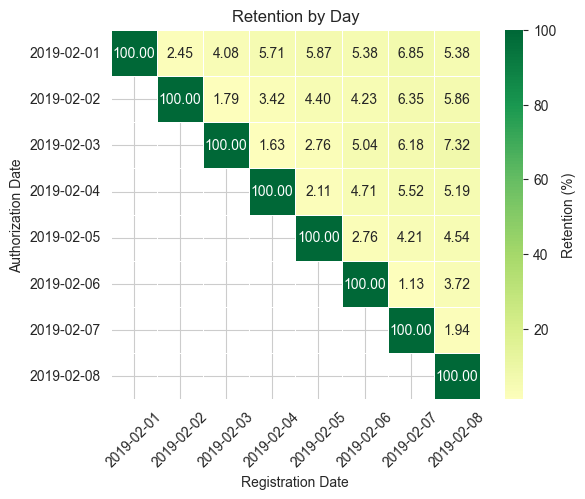

In [40]:
# Creating a heatmap using my function
sns.heatmap(retention_per_day(reg_data, auth_data, "2019-02-01", "2019-02-08"), annot=True, fmt='.2f', cmap='RdYlGn', center=0, linewidths=.5, cbar_kws={'label': 'Retention (%)'}, square=True)
plt.xticks(rotation=45);
plt.title("Retention by Day");
plt.xlabel("Registration Date");
plt.ylabel("Authorization Date");

plt.show()